In [6]:
## required packages for this Chapter
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

# Question 2

The link4 to the Grid network (Europe) also has data for North America. Perform a similar type of EDA as in Section 1.12 (in particular, replicate Table 1.1) for that graph, including getting and preparing the data (which is usually the most time consuming part of the process). The raw downloaded files can be also found in Datasets/GridNorthAmerica in the additional material from the book’s web site. You may have a look at the raw files and the processed data in Datasets/GridEurope and do the same for North America.

In [2]:
## read edge list for the grid network and build undirected graph
D = pd.read_csv('gridkit_north_america-highvoltage-links.csv')
Dnew = D[['v_id_1', 'v_id_2']].copy()
tuples = [tuple(x) for x in Dnew.values]
gr = ig.Graph.TupleList(tuples, directed = False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv('gridkit_north_america-highvoltage-vertices.csv')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

In [3]:
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['Grid'] + baseStats(gr))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

C:\Users\Brandon\AppData\Local\Temp/ipykernel_28204/1925536392.py:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),


,0
graph,Grid
nodes,16167
edges,20242
$d_{min}$,1
$d_{mean}$,2.504113
$d_{median}$,2.0
$d_{quant_{99}}$,7.0
$d_{max}$,22
diameter,138
components,34


# Question 3

Consider the GitHub (ml) graph on 9,739 nodes.

In [177]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] 
lbl = ['web','ml']     
gh.es['color'] = 'grey' 

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])


In [3]:
adj = gh_ml.get_adjacency()
adj = np.array(adj.data)
walk_adj = np.linalg.matrix_power(adj, 5)
walk_num = np.sum(walk_adj)

a. Find the number of walks of length 5.

In [4]:
walk_num

1815466386

b. Find the number of cycles of length 4 (induced, that is, without chords).

In [33]:
gh_ml.motifs_randesu_no(size=4)

53872539

# Question 4

Consider the airport graph found in the additional material from the book’s web site under Datasets/Airport/airport data.csv. The first 3 fields are: the origin, the destination and, respectively, the number of passengers. This graph is weighted and directed; the weight of a directed edge uv corresponds to the number of passen- gers travelling from airport u to airport v.

a. Plot the cumulative degree distribution (points (l, n≥l), where n≥l is the number of nodes of degree at least l ≥ 1) in the log-log plot. Find the slope of the line obtained via linear re- gression.


Regression Coefficient: 0.29630541010964406


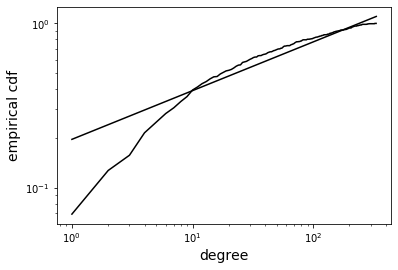

In [175]:
D = pd.read_csv('connections.csv')
X = pd.read_csv('airports_loc.csv')

#Z = (D.merge(X, left_on='orig_airport', right_on='airport'))

tuples = [tuple(x) for x in D.values]
ag = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])
for s in ag.vs:
    s['lon'] = X.loc[X['airport'] == s['name'], 'lon'].iloc[0]
    s['lat'] = X.loc[X['airport'] == s['name'], 'lat'].iloc[0]
    s['state'] = X.loc[X['airport'] == s['name'], 'state'].iloc[0]
    s['city'] = X.loc[X['airport'] == s['name'], 'city'].iloc[0]


deg = ag.degree()
e = ecdf(deg)
x = np.arange(1,ag.maxdegree(),1)
y = [e(i) for i in x]
plt.loglog(x,y,'-',color='black',label='Grid')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);

regressor = LinearRegression()  
r = [np.log(i) for i in x]
z = [np.log(i) for i in y]

mindeg = 1
maxdeg = ag.maxdegree()

regressor.fit(np.array(r).reshape(-1,1), z)
b = regressor.intercept_
a = regressor.coef_[0]
plt.plot([mindeg,maxdeg],[np.exp(b)*mindeg**a,np.exp(b)*maxdeg**a],color='black')

print('Regression Coefficient:',regressor.coef_[0])

b.Find the busiest airport. In other words, find the node with the maximum total degree (degin(v) + degout(v)).


In [70]:
max_deg = max(ag.degree())
busy_airport = ag.vs.find(_degree=max_deg)
print('Busiest Airport:', busy_airport['name'])

Busiest Airport: ATL


c.Find the number of strongly connected components.

In [92]:
strong_graph = ag.connected_components(mode='strong')
print('Number of Strongly Connected Comoponents:',len(strong_graph))

Number of Strongly Connected Comoponents: 40


d.Find the subgraph induced by all airports from California. Find the number of isolated nodes in this subgraph.

In [191]:
ca = ag.subgraph([v for v in ag.vs() if v['state']=='CA'])
iso_ca = ca.vs.select(_degree=0)

print('Isolated in CA induced graph:', len(iso_ca))

Isolated in CA induced graph: 9


# Question 5

Take 100 random pairs of nodes in the European Grid network. For each pair plot a point (x, y), where x is the graph distance between the two nodes and y is the corresponding geographical distance (in kilometres). Is there a correlation between the two distances? In order to compute the geographical distance you may, for example, use function geodesic from geopy package or implement it from scratch using the haversine formula that determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [7]:
import igraph as ig
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

In [8]:
D = pd.read_csv('gridkit_europe-highvoltage-links.csv')
Dnew = D[['v_id_1', 'v_id_2']].copy()
tuples = [tuple(x) for x in Dnew.values]
gr = ig.Graph.TupleList(tuples, directed = False)
gr = gr.simplify()
X = pd.read_csv('gridkit_europe-highvoltage-vertices.csv')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] 
gr.vs['size'] = 3

In [9]:
sg = gr.clusters().giant()

/var/folders/05/62lgrwmj4nz80f41r9vl6ylc0000gn/T/ipykernel_48543/2704587549.py:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  sg = gr.clusters().giant()


In [10]:
lt1=np.random.choice(sg.vcount(), size=100, replace=False)
lt2=np.random.choice(sg.vcount(), size=100, replace=False)
path_lengths=[]
for i in range(100):
    path_lengths.extend(sg.distances(lt1[i], lt2[i])[0])
vertices1 = [(sg.vs[lt1[i]]['latitude'],sg.vs[lt1[i]]['longitude']) for i in range(100)]
vertices2 = [(sg.vs[lt2[i]]['latitude'],sg.vs[lt2[i]]['longitude']) for i in range(100)]
geo_distances = [GD(vertices1[i],vertices2[i]).km for i in range(100)]

In [11]:
data_source = pd.DataFrame({'Graph Distance' : path_lengths,
                                'Geo Distance' : geo_distances}, 
                                columns=['Graph Distance','Geo Distance'])
data_source.sort_values(by=['Graph Distance'])

,Graph Distance,Geo Distance
80,8,447.802846
2,9,358.305352
48,11,120.444530
25,12,970.014709
1,13,68.939394
...,...,...
79,81,417.751794
10,82,274.698777
89,84,260.220685
50,84,150.090300


[Text(0.5, 0, 'Graph Distance'),
 Text(0, 0.5, 'Geographical Distance (in Kilometres)'),
 Text(0.5, 1.0, 'Scatterplot of Graph Distance vs Geographical Distance')]

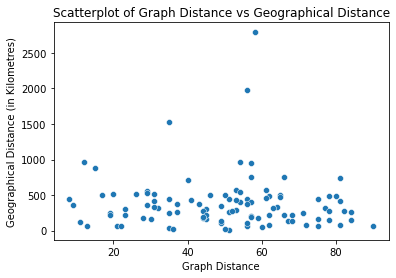

In [12]:
fig=sns.scatterplot(data = data_source, x="Graph Distance", y="Geo Distance")
fig.set(xlabel="Graph Distance", ylabel="Geographical Distance (in Kilometres)",title='Scatterplot of Graph Distance vs Geographical Distance')


No clear correlation can be seen between the graph distance and the grographical distances(x and y).